# Setup

In [4]:
import pandas as pd
from pandas import Index, RangeIndex
import numpy as np
import math
import logging
import random
import os
import time
import csv
from collections.abc import Iterable


from causalAssembly.models_dag import ProductionLineGraph
from causalAssembly.drf_fitting import fit_drf

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import Notears
# adjust GAE algorithm
# from castle.algorithms import GAE
from castle.algorithms import DirectLiNGAM
from castle.algorithms import PC

from dagma.linear import DagmaLinear

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import networkx as nx
import matplotlib.pyplot as plt

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-03 09:24:22,347 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-07-03 09:24:22,408 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [14]:
LOG_FREQUENCY = 100


def set_seed(seed):
    """
    Referred from:
    - https://stackoverflow.com/questions/38469632/tensorflow-non-repeatable-results
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        os.environ['PYTHONHASHSEED'] = str(seed)
    except Exception:
        pass


def compute_h(w_adj):

    d = w_adj.shape[0]
    h = torch.trace(torch.matrix_exp(w_adj * w_adj)) - d

    return h


class Tensor(np.ndarray):
    """A subclass of numpy.ndarray.

    This subclass has all attributes and methods of numpy.ndarray
    with two additional, user-defined attributes: `index` and `columns`.

    It can be used in the same way as a standard numpy.ndarray.
    However, after performing any operations on the Tensor (e.g., slicing,
    transposing, arithmetic, etc.), the user-defined attribute values of
    `index` and `columns` will be lost and replaced with a numeric indices.

    Parameters
    ----------
    object: array-like
        Multiple list, ndarray, DataFrame
    index : Index or array-like
        Index to use for resulting tensor. Will default to RangeIndex if
        no indexing information part of input data and no index provided.
    columns : Index or array-like
        Column labels to use for resulting tensor. Will default to
        RangeIndex (0, 1, 2, ..., n) if no column labels are provided.

    Examples
    --------
    Create a Tensor from a list or numpy.ndarray.

    >>> x = [[0, 3, 8, 1],
    ...      [8, 4, 1, 9],
    ...      [7, 3, 3, 7]]

    Or

    >>> x = np.random.randint(0, 10, size=12).reshape((3, 4))
    >>> arr = Tensor(x)
    >>> arr
    Tensor([[0, 3, 8, 1],
            [8, 4, 1, 9],
            [7, 3, 3, 7]])
    >>> arr.index
    RangeIndex(start=0, stop=3, step=1)
    >>> list(arr.index)
    [0, 1, 2]
    >>> arr.columns
    RangeIndex(start=0, stop=4, step=1)
    >>> list(arr.columns)
    [0, 1, 2, 3]

    `index` and `columns` can be set using kwargs.

    >>> arr = Tensor(x, index=list('XYZ'), columns=list('ABCD'))
    >>> arr
    Tensor([[6, 1, 8, 9],
            [1, 5, 2, 1],
            [5, 9, 4, 5]])
    >>> arr.index
    Index(['x', 'y', 'z'], dtype='object')
    >>> arr.columns
    Index(['a', 'b', 'c', 'd'], dtype='object')

    Or a value can be assigned to `arr.index` or `arr.columns`,
    but it must be an `Iterable`.

    >>> arr.index = list('xyz')
    >>> arr.index
    Index(['x', 'y', 'z'], dtype='object')
    >>> arr.columns = list('abcd')
    >>> arr.columns
    Index(['a', 'b', 'c', 'd'], dtype='object')

    A Tensor can also be created from a pandas.DataFrame.

    >>> x = pd.DataFrame(np.random.randint(0, 10, size=12).reshape((3, 4)),
    ...                  index=list('xyz'),
    ...                  columns=list('abcd'))
    >>> x
       a  b  c  d
    x  6  1  8  9
    y  1  5  2  1
    z  5  9  4  5
    >>> arr = Tensor(x)
    >>> arr
    Tensor([[6, 1, 8, 9],
            [1, 5, 2, 1],
            [5, 9, 4, 5]])
    >>> arr.index
    Index(['x', 'y', 'z'], dtype='object')
    >>> arr.columns
    Index(['a', 'b', 'c', 'd'], dtype='object')

    It's possible to use any method of numpy.ndarray on the Tensor,
    such as `sum`, `@`, etc.

    >>> arr.sum(axis=0)
    Tensor([15, 10, 12, 17])
    >>> arr @ arr.T
    Tensor([[ 74,  29,  40],
            [ 29, 162, 134],
            [ 40, 134, 116]])

    If the Tensor is sliced, the values of `index` and `columns` will disappear,
    and new values of type `RangeIndex` will be created.

    >>> new_arr = arr[:, 1:3]
    >>> new_arr
    Tensor([[1, 8],
            [5, 2],
            [9, 4]])
    >>> new_arr.index
    RangeIndex(start=0, stop=3, step=1)
    >>> new_arr.columns
    RangeIndex(start=0, stop=2, step=1)

    If you want to retain the values of `index` and `columns`,
    you can reassign them.

    >>> new_arr.index = arr.index[:]
    >>> new_arr.index
    Index(['x', 'y', 'z'], dtype='object')

    >>> new_arr.columns = arr.columns[1:3]
    >>> new_arr.columns
    Index(['b', 'c'], dtype='object')

    We recommend performing slicing operations in the following way
    to keep the `index` and `columns` values.

    >>> new_arr = Tensor(array=arr[:, 1:3],
    ...                  index=arr.index[:, 1:3],
    ...                  columns=arr.columns[:, 1:3])
    >>> new_arr.index
    Index(['x', 'y', 'z'], dtype='object')
    >>> new_arr.columns
    Index(['b', 'c'], dtype='object')
    """

    def __new__(cls, object=None, index=None, columns=None):

        if object is None:
            raise TypeError("Tensor() missing required argument 'object' (pos 0)")
        elif isinstance(object, list):
            object = np.array(object)
        elif isinstance(object, pd.DataFrame):
            index = object.index
            columns = object.columns
            object = object.values
        elif isinstance(object, (np.ndarray, cls)):
            pass
        else:
            raise TypeError(
                "Type of the required argument 'object' must be array-like."
            )
        if index is None:
            index = range(object.shape[0])
        if columns is None:
            columns = range(object.shape[1])
        obj = np.asarray(object).view(cls)
        obj.index = index
        obj.columns = columns

        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        if self.ndim == 0: return
        elif self.ndim == 1:
            self.columns = RangeIndex(0, 1, step=1, dtype=int)
        else:
            self.columns = RangeIndex(0, self.shape[1], step=1, dtype=int)
        self.index = RangeIndex(0, self.shape[0], step=1, dtype=int)

    @property
    def index(self):
        return self._index

    @index.setter
    def index(self, value):
        assert isinstance(value, Iterable)
        if len(list(value)) != self.shape[0]:
            raise ValueError("Size of value is not equal to the shape[0].")
        self._index = Index(value)

    @property
    def columns(self):
        return self._columns

    @columns.setter
    def columns(self, value):
        assert isinstance(value, Iterable)
        if (self.ndim > 1 and len(list(value)) != self.shape[1]):
            raise ValueError("Size of value is not equal to the shape[1].")
        self._columns = Index(value)


class ALTrainer(object):

    def __init__(self, n, d, model, lr, init_iter, alpha, beta, rho, rho_thresh,
                 h_thresh, l1_penalty, gamma, early_stopping,
                 early_stopping_thresh, seed, device=None):
        self.n = n
        self.d = d
        self.model = model
        self.lr = lr
        self.init_iter = init_iter

        self.alpha = alpha
        self.beta = beta  # rho_multiply
        self.rho = rho
        self.rho_thresh = rho_thresh
        self.h_thresh = h_thresh  # 1e-8
        self.l1_penalty = l1_penalty
        self.gamma = gamma
        self.early_stopping = early_stopping
        self.early_stopping_thresh = early_stopping_thresh
        self.seed = seed
        self.device = device

        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=self.lr)

    def train(self, x, epochs, update_freq):

        alpha, beta, rho = self.alpha, self.beta, self.rho
        h, h_new = np.inf, np.inf
        prev_w_est, prev_mse = None, np.inf
        for epoch in range(1, epochs + 1):
            logging.info(f'Current epoch: {epoch}==================')
            while rho < self.rho_thresh:
                mse_new, h_new, w_new = self.train_step(x,
                                                        update_freq,
                                                        alpha,
                                                        rho)
                if h_new > self.gamma * h:
                    rho *= self.beta
                else:
                    break
            logging.info(f'Current        h: {h_new}')

            if self.early_stopping:
                if (mse_new / prev_mse > self.early_stopping_thresh
                        and h_new <= 1e-7):
                    return prev_w_est
                else:
                    prev_w_est = w_new
                    prev_mse = mse_new

            # update rules
            w_est, h = w_new, h_new
            alpha += rho * h_new.detach().cpu()

            if h <= self.h_thresh and epoch > self.init_iter:
                break

        return w_est


    def train_step(self, x, update_freq, alpha, rho):

        curr_mse, curr_h, w_adj = None, None, None
        for _ in range(update_freq):
            torch.manual_seed(self.seed)
            curr_mse, w_adj = self.model(x)
            curr_h = compute_h(w_adj)
            loss = ((0.5 / self.n) * curr_mse
                    + self.l1_penalty * torch.norm(w_adj, p=1)
                    + alpha * curr_h + 0.5 * rho * curr_h * curr_h)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if _ % LOG_FREQUENCY == 0:
                logging.info(f'Current loss in step {_}: {loss.detach()}')

        return curr_mse, curr_h, w_adj


class MLP(nn.Module):
    """
    Feed-forward neural networks----MLP

    """

    def __init__(self, input_dim, layers, units, output_dim,
                 activation=None, device=None) -> None:
        super(MLP, self).__init__()
        # self.desc = desc
        self.input_dim = input_dim
        self.layers = layers
        self.units = units
        self.output_dim = output_dim
        self.activation = activation
        self.device = device

        mlp = []
        for i in range(layers):
            input_size = units
            if i == 0:
                input_size = input_dim
            weight = nn.Linear(in_features=input_size,
                               out_features=self.units,
                               bias=True,
                               device=self.device)
            mlp.append(weight)
            if activation is not None:
                mlp.append(activation)
        out_layer = nn.Linear(in_features=self.units,
                              out_features=self.output_dim,
                              bias=True,
                              device=self.device)
        mlp.append(out_layer)

        self.mlp = nn.Sequential(*mlp)

    def forward(self, x) -> torch.Tensor:

        x_ = x.reshape(-1, self.input_dim)
        output = self.mlp(x_)

        return output.reshape(x.shape[0], -1, self.output_dim)


class AutoEncoder(nn.Module):

    def __init__(self, d, input_dim, hidden_layers=3, hidden_dim=16,
                 activation=nn.ReLU(), device=None):
        super(AutoEncoder, self).__init__()
        self.d = d
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.device = device

        self.encoder = MLP(input_dim=self.input_dim,
                           layers=self.hidden_layers,
                           units=self.hidden_dim,
                           output_dim=self.hidden_dim,
                           activation=self.activation,
                           device=self.device)
        self.decoder = MLP(input_dim=self.hidden_dim,
                           layers=self.hidden_layers,
                           units=self.hidden_dim,
                           output_dim=self.input_dim,
                           activation=self.activation,
                           device=self.device)

        w = torch.nn.init.uniform_(torch.empty(self.d, self.d,),
                                   a=-0.1, b=0.1)
        self.w = torch.nn.Parameter(w.to(device=self.device))

    def forward(self, x):

        self.w_adj = self._preprocess_graph(self.w)

        out = self.encoder(x)
        out = torch.einsum('ijk,jl->ilk', out, self.w_adj)
        # x_est = self.decoder(out)
        x_est = torch.sigmoid(self.decoder(out))

        # mse_loss = torch.square(torch.norm(x - x_est, p=2))
        mse_loss = F.binary_cross_entropy(x, x_est)


        return mse_loss, self.w_adj

    def _preprocess_graph(self, w_adj):

        return (1. - torch.eye(w_adj.shape[0], device=self.device)) * w_adj


class GAE:
    """
    GAE Algorithm.
    A gradient-based algorithm using graph autoencoder to model non-linear
    causal relationships.

    Parameters
    ----------
    input_dim: int, default: 1
        dimension of vector for x
    hidden_layers: int, default: 1
        number of hidden layers for encoder and decoder
    hidden_dim: int, default: 4
        hidden size for mlp layer
    activation: callable, default: nn.LeakyReLU(0.05)
        nonlinear functional
    epochs: int, default: 10
        Number of iterations for optimization problem
    update_freq: int, default: 3000
        Number of steps for each iteration
    init_iter: int, default: 3
        Initial iteration to disallow early stopping
    lr: float, default: 1e-3
        learning rate
    alpha: float, default: 0.0
        Lagrange multiplier
    beta: float, default: 2.0
        Multiplication to amplify rho each time
    init_rho: float, default: 1.0
        Initial value for rho
    rho_thresh: float, default: 1e30
        Threshold for rho
    gamma: float, default: 0.25
        Threshold for h
    penalty_lambda: float, default: 0.0
        L1 penalty for sparse graph. Set to 0.0 to disable
    h_thresh: float, default: 1e-8
        Tolerance of optimization problem
    graph_thresh: float, default: 0.3
        Threshold to filter out small values in graph
    early_stopping: bool, default: False
        Whether to use early stopping
    early_stopping_thresh: float, default: 1.0
        Threshold ratio for early stopping
    seed: int, default: 1230
        Reproducibility, must be int
    device_type: str, default: 'cpu'
        'cpu' or 'gpu'
    device_ids: int or str, default '0'
        CUDA devices, it's effective when ``use_gpu`` is True.
        For single-device modules, ``device_ids`` can be int or str,
        e.g. 0 or '0', For multi-device modules, ``device_ids`` must be str,
        format like '0, 1'.
    """

    def __init__(self,
                 input_dim=1,
                 hidden_layers=1,
                 hidden_dim=4,
                 activation=torch.nn.LeakyReLU(0.05),
                 epochs=10,
                 update_freq=3000,
                 init_iter=3,
                 lr=1e-3,
                 alpha=0.0,
                 beta=2.0,
                 init_rho=1.0,
                 rho_thresh=1e30,
                 gamma=0.25,
                 penalty_lambda=0.0,
                 h_thresh=1e-8,
                 graph_thresh=0.3,
                 early_stopping=False,
                 early_stopping_thresh=1.0,
                 seed=1230,
                 device_type='cpu',
                 device_ids='0'):

        super(GAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.epochs = epochs
        self.update_freq = update_freq
        self.init_iter = init_iter
        self.lr = lr
        self.alpha = alpha
        self.beta = beta
        self.init_rho = init_rho
        self.rho_thresh = rho_thresh
        self.gamma = gamma
        self.penalty_lambda = penalty_lambda
        self.h_thresh = h_thresh
        self.graph_thresh = graph_thresh
        self.early_stopping = early_stopping
        self.early_stopping_thresh = early_stopping_thresh
        self.seed = seed
        self.device_type = device_type
        self.device_ids = device_ids

        if torch.cuda.is_available():
            logging.info('GPU is available.')
        else:
            logging.info('GPU is unavailable.')
            if self.device_type == 'gpu':
                raise ValueError("GPU is unavailable, "
                                 "please set device_type = 'cpu'.")
        if self.device_type == 'gpu':
            if self.device_ids:
                os.environ['CUDA_VISIBLE_DEVICES'] = str(self.device_ids)
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
        self.device = device

    def learn(self, data, columns=None, **kwargs):

        x = torch.from_numpy(data)

        self.n, self.d = x.shape[:2]
        if x.ndim == 2:
            x = x.reshape((self.n, self.d, 1))
            self.input_dim = 1
        elif x.ndim == 3:
            self.input_dim = x.shape[2]

        w_est = self._gae(x).detach().cpu().numpy()

        self.weight_causal_matrix = Tensor(w_est,
                                           index=columns,
                                           columns=columns)
        causal_matrix = (abs(w_est) > self.graph_thresh).astype(int)
        self.causal_matrix = Tensor(causal_matrix,
                                    index=columns,
                                    columns=columns)

    def _gae(self, x):

        set_seed(self.seed)
        model = AutoEncoder(d=self.d,
                            input_dim=self.input_dim,
                            hidden_layers=self.hidden_layers,
                            hidden_dim=self.hidden_dim,
                            activation=self.activation,
                            device=self.device,
                            )
        trainer = ALTrainer(n=self.n,
                            d=self.d,
                            model=model,
                            lr=self.lr,
                            init_iter=self.init_iter,
                            alpha=self.alpha,
                            beta=self.beta,
                            rho=self.init_rho,
                            l1_penalty=self.penalty_lambda,
                            rho_thresh=self.rho_thresh,
                            h_thresh=self.h_thresh,  # 1e-8
                            early_stopping=self.early_stopping,
                            early_stopping_thresh=self.early_stopping_thresh,
                            gamma=self.gamma,
                            seed=self.seed,
                            device=self.device)
        w_est = trainer.train(x=x,
                              epochs=self.epochs,
                              update_freq=self.update_freq)
        w_est = w_est / torch.max(abs(w_est))

        return w_est

In [3]:
#  set up testing collection df

testing_results_columns = ['date', 'dataset', 'subset', 'n', 'method', 'runtime', 'hyperparams',
                                        'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore']

# Check if the file exists
try:
    with open('testing_results.csv', 'r') as csvfile:
        print("File 'testing_results.csv' already exists.")
except FileNotFoundError:
    # Create a new file with the specified columns
    with open('testing_results.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(testing_results_columns)
        print("New file 'testing_results.csv' created with the specified columns.")


File 'testing_results.csv' already exists.


In [5]:
#  Function to save the date to the testing_results.csv

def add_results(dataset, subset, n, method, runtime, hyperparams, metrics):
    with open('testing_results.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        if metrics != None:
            writer.writerow([time.strftime("%Y-%m-%d %H:%M:%S"), 
                            dataset, 
                            subset,
                            n, 
                            method, 
                            runtime, 
                            hyperparams,
                            metrics['fdr'],
                            metrics['tpr'],
                            metrics['fpr'],
                            metrics['shd'],
                            metrics['nnz'],
                            metrics['precision'],
                            metrics['recall'],
                            metrics['F1'],
                            metrics['gscore']]
                            )
        else:
            writer.writerow([time.strftime("%Y-%m-%d %H:%M:%S"), 
                            dataset, 
                            subset,
                            n, 
                            method, 
                            runtime, 
                            hyperparams,
                            ]
                            )
        print("Results added to 'testing_results.csv'.")

In [11]:
# Function to generate and save a graph plot next to a heatmap

def plot_graph_adjacency_matrix(ground_truth, save_name):

    # create figure
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 8), ncols=2)

    # subplot for graph
    ax1.set_title('Graph', y= 1.05)
    G = nx.from_numpy_matrix(ground_truth, create_using=nx.DiGraph)
    nx.draw(G, ax=ax1, with_labels=True)

    # subplot for heatmap
    ax2.set_title('Adjazenzmatrix Heat Map', y= 1.05)
    map1 = ax2.imshow(ground_truth, cmap='Greys', interpolation='none')
    cbar = fig.colorbar(map1, ax=ax2)
    cbar.ax.set_position([cbar.ax.get_position().x0, ax2.get_position().y0,
                        cbar.ax.get_position().width, ax2.get_position().height])

    # Ensure subplots have same height and position in y direction
    ax1_height = ax2.get_position().height
    ax1.set_position([ax1.get_position().x0, ax2.get_position().y0,
                    ax1.get_position().width, ax1_height])
    ax2.set_position([ax2.get_position().x0, ax2.get_position().y0,
                    ax2.get_position().width, ax1_height])

    # save
    plt.savefig(save_name)
    plt.show()

In [7]:
# function to only save a heat map

def plot_heatmap(ground_truth, method, save_name):
    
    # create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # subplot for heatmap
    ax.set_title(method, y= 1.05)
    map1 = ax.imshow(ground_truth, cmap='Greys', interpolation='none')
    cbar = fig.colorbar(map1, ax=ax)
    cbar.ax.set_position([cbar.ax.get_position().x0, ax.get_position().y0,
                        cbar.ax.get_position().width, ax.get_position().height])

    # save
    plt.savefig(save_name)
    plt.show()

In [13]:
# test setup

def run_tests(dataset, subset, algorithms, sample_sizes, ground_truth_available:bool):
    
    if ground_truth_available:
        ground_truth = pd.read_csv(f'data/{dataset}/{subset}/{subset}_ground_truth.csv').to_numpy()

    algorithms_gcastle = ['NotearsLinear', 'GAE', 'DirectLiNGAM', 'PC']	
    
    for sample_size in sample_sizes:

        data = pd.read_csv(f'data/{dataset}/{subset}/{subset}_data_{sample_size}.csv').to_numpy()

        # go over all algorithms
        for algorithm in algorithms:

            # set different params for the different models
            match algorithm:

                case 'NotearsLinear':
                    model = Notears(loss_type='logistic')
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()             

                case 'DagmaLinear':
                    model = DagmaLinear(loss_type='logistic')
                    start_time = time.time()
                    W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
                    end_time = time.time()

                case 'GAE':
                    model = GAE(epochs=3)
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()

                case 'DirectLiNGAM':
                    model = DirectLiNGAM()
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()

                case 'PC':
                    model = PC(variant = 'stable')
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()


            # calculate runtime
            runtime = end_time - start_time

            # plot comparison graph
            name = f'{algorithm}_{sample_size}'
            print(name)
            save_name1 = f'plots/adj_matrix_comparison/{dataset}/{subset}/{name}.png'

            # plot only heatmap for later comparison
            save_name2 = f'plots/adj_matrix/{dataset}/{subset}/{name}.png'

            # save adj_matrix as csv
            save_name3 = f'plots/adj_matrix_csv/{dataset}/{subset}/{name}.csv'

            match algorithm:

                case algorithm if algorithm in algorithms_gcastle:
                    if ground_truth_available:
                        met = MetricsDAG(model.causal_matrix, ground_truth).metrics
                        GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                    elif not ground_truth_available:
                        met = None
                    plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                    df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))

                case 'DagmaLinear':
                    if ground_truth_available:
                        met = MetricsDAG(W_est, ground_truth).metrics
                        GraphDAG(W_est, ground_truth, save_name = save_name1)
                    elif not ground_truth_available:
                        met = None
                    plot_heatmap(W_est, method = algorithm, save_name = save_name2)
                    df = pd.DataFrame(np.array(W_est.tolist()).reshape(W_est.shape))

                # case 'NotearsLinear':
                #     met = MetricsDAG(model.causal_matrix, ground_truth)
                #     GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                #     plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                #     df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))
                # case 'DagmaLinear':
                #     met = MetricsDAG(W_est, ground_truth)
                #     GraphDAG(W_est, ground_truth, save_name = save_name1)
                #     plot_heatmap(W_est, method = algorithm, save_name = save_name2)
                #     df = pd.DataFrame(np.array(W_est.tolist()).reshape(W_est.shape))
                # case 'GAE':
                #     met = MetricsDAG(model.causal_matrix, ground_truth)
                #     GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                #     plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                #     df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))
                # case 'DirectLiNGAM':
                #     met = MetricsDAG(model.causal_matrix, ground_truth)
                #     GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                #     plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                #     df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))
                # case 'PC':
                #     met = MetricsDAG(model.causal_matrix, ground_truth)
                #     GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                #     plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                #     df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))

            # save adj matrix to csv
            df.to_csv(save_name3, index=False)

            # save metrics to csv
            add_results(dataset, subset, sample_size, algorithm, runtime, None, met) 

# TESTING

In [15]:
# define testing parameters

algorithms = [
              # 'NotearsLinear'
              # , 'DagmaLinear'
              # 'GAE'
            #   , 'DirectLiNGAM'
              'PC'
              ]

sample_sizes = [500]

datasets = ['IID']
subsets = ['IID3']

# change between experiments where the ground truth is known and those where it is not
ground_truth_available = False

runs = range(0,1)

# from castle.algorithms import GAE

File 'IID3_data_500.csv' exists.
PC_500


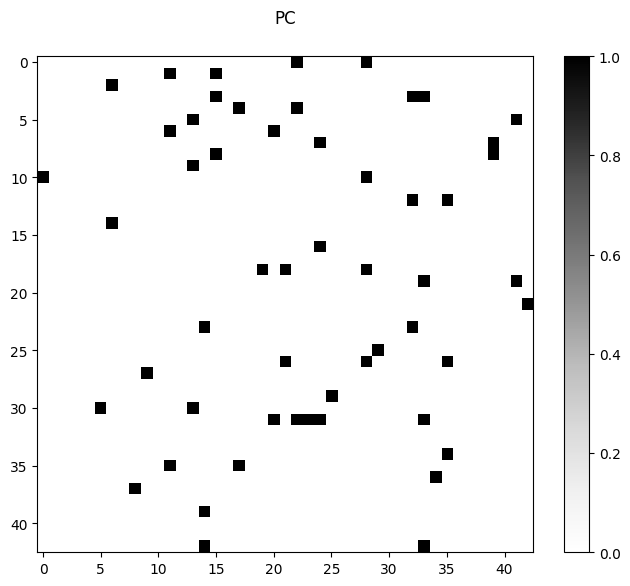

Results added to 'testing_results.csv'.


In [14]:
for run in runs:
    for dataset in datasets:
        for subset in subsets:
            # check if a file exists in the data folder and if yes, do run_tests
            try:
                with open(f'data/{dataset}/{subset}/{subset}_data_{sample_sizes[0]}.csv', 'r') as csvfile:
                    print(f"File '{subset}_data_{sample_sizes[0]}.csv' exists.")
                    run_tests(dataset, subset, algorithms, sample_sizes, ground_truth_available)
            except FileNotFoundError:
                print(f"The combination of {dataset} and {subset} does not exist.")
                pass
        
